In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('../..'))
from project_paths import PROJECT_ROOT
from file_handler import HistoryHandler
from functions import compute_RE, get_timing_info
from Paper.figure_scripts import common

In [2]:
L = 10
arch = f"ResCNN_nblocks4_nfilters16_KernelShape3x3"
n_dim = 2
PBC = True
dtype_labels = [None, "f32", "f16", "bf16"]
model_label = "TFIM"
hs = np.array([1, 3.04438, 5])
model_params = [{"J": 1, "h": h} for h in hs]
dmrg = False

n_samples=2**12
n_chains=2**10

folder = f"{PROJECT_ROOT}Data/History/"

In [3]:
loss_functions = [[None for _ in dtype_labels] for _ in hs]
variance = [[None for _ in dtype_labels] for _ in hs]
total_time = [[None for _ in dtype_labels] for _ in hs]
energy = [[None for _ in dtype_labels] for _ in hs]
re = [[None for _ in dtype_labels] for _ in hs]
timinig_info = [[None for _ in dtype_labels] for _ in hs]
sigma = [[None for _ in dtype_labels] for _ in hs]

for h in range(len(hs)):
    for d in range(len(dtype_labels)):
        if dtype_labels[d] is not None:
                _folder = f"LPS/{dtype_labels[d]}/"
        else:
            _folder = "" 
        name = f"{folder}{_folder}MC/"
        hh = HistoryHandler(name, model_label, arch, L, PBC, n_dim, **model_params[h], n_samples=n_samples, n_chains=n_chains)
        df = hh.load_history()

        loss_functions[h][d] = df["Mean"].to_numpy()
        variance[h][d] = df["Variance"].to_numpy()
        total_time[h][d] = df["total_time"].to_numpy()[0]
        energy[h][d] = df["Mean"].to_numpy()
        sigma[h][d] = df['sigma'].to_numpy()
        timinig_info[h][d] = get_timing_info(hh.history_file)

dtype_labels[0] = "f64"

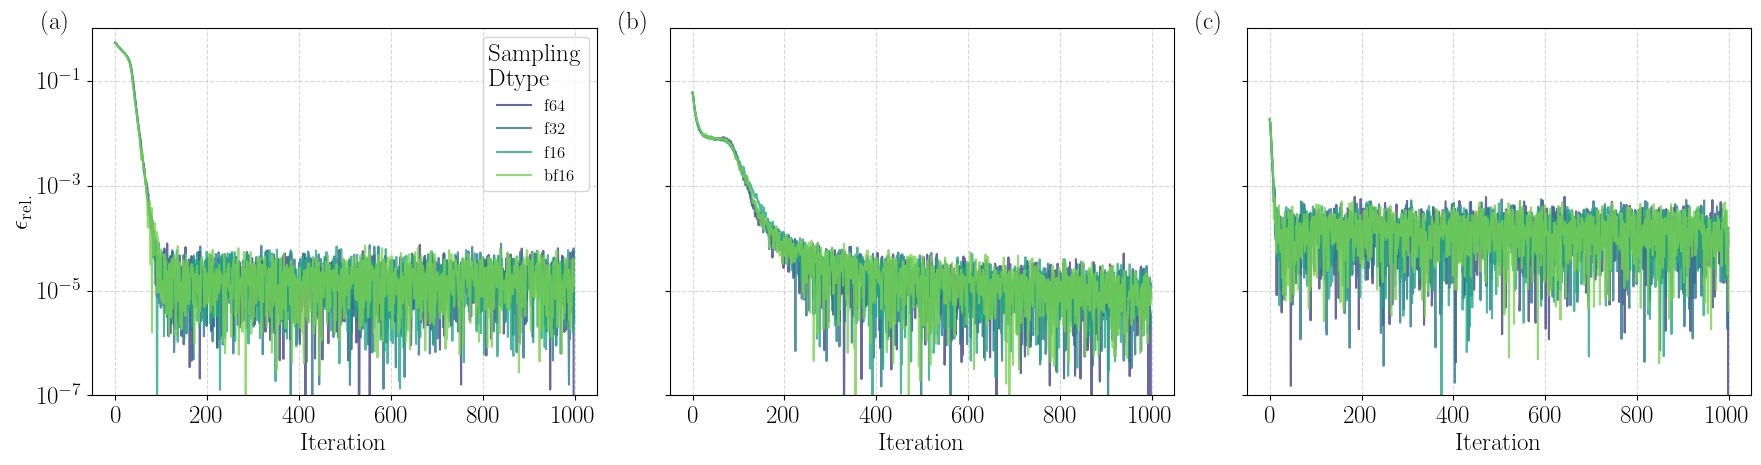

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(dtype_labels)))

fig, axes = plt.subplots(1, len(hs), figsize=(18, 5), sharey=True)

labels = ['AF', 'PT', 'PM']


for h, ax_main in enumerate(axes):

    for d in range(len(dtype_labels)):
        x = np.arange(len(loss_functions[h][d]))
        y = np.abs(loss_functions[h][d] - loss_functions[h][0][-1]) / np.abs(loss_functions[h][0][-1])
        ax_main.plot(x, y, color=colors[d], label=dtype_labels[d], alpha=0.8)
    ax_main.text(-0.1, 1.05, f'({chr(97+h)})', transform=ax_main.transAxes, fontweight='bold', va='top')

    ax_main.set_xlabel("Iteration")
    ax_main.set_yscale("log")
    ax_main.set_ylim(1e-7, 1e-0)
    ax_main.grid(True, linestyle="--", alpha=0.5)

    if h == 0:
        ax_main.set_ylabel(r"$\epsilon_{\text{rel.}}$")

        ax_main.legend(
            title="Sampling \n Dtype",
            loc="upper right",
            frameon=True
        )

plt.tight_layout()
plt.savefig("figures/loss_function_ResCNN.pdf")
plt.show()